In [1]:
with open('bitmex_file.txt', 'r') as f:
    i = 0
    for line in f:
        i += 1
        print(line)
        if i == 50:
            break
        

23-03-01 13:56:14.206570 [INFO simulation/any_file_event_provider.cpp:24] Read events from binary data: bitmex_XBTUSD_20230130.bin

23-01-30 00:00:00.141480 type: OrderbookSnapshot symbol: none symbol_id: none receive_time: 23-01-30 00:00:00.141480 server_time: 1675036800123000 orderbook:  bid_size: 0 ask_size: 0



23-01-30 00:00:00.142054 type: OrderbookSnapshot symbol: none symbol_id: none receive_time: 23-01-30 00:00:00.142054 server_time: 1675036800123000 orderbook:  bid_size: 1 ask_size: 0

Bid price: 23516.500000 volume: 4900.000000



23-01-30 00:00:00.143591 type: OrderbookSnapshot symbol: none symbol_id: none receive_time: 23-01-30 00:00:00.143591 server_time: 1675036800124000 orderbook:  bid_size: 2 ask_size: 0

Bid price: 23736.500000 volume: 11900.000000

Bid price: 23516.500000 volume: 4900.000000



23-01-30 00:00:00.143945 type: OrderbookSnapshot symbol: none symbol_id: none receive_time: 23-01-30 00:00:00.143945 server_time: 1675036800131000 orderbook:  bid_size: 2 ask

Спарсим цены ask и bid, которые определяют spread.

In [2]:
from talib import MA, BBANDS, MACD, RSI
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
import re
from math import floor

plt.rcParams['figure.figsize'] = (20, 10)
plt.style.use('fivethirtyeight')

In [3]:
with open('bitmex_file.txt', 'r') as f:
    ask = []
    bid = []
    lst = []
    i = 0
    for line in tqdm(f):
        lst.append(line)
        i += 1
        if i % 1000 == 0:
            s = ''.join(lst)
            spread = re.findall(r"Ask price: \d+\.\d+ volume: \d+\.\d+\sBid price: \d+\.\d+ volume: \d+\.\d+\s", s)
            for ex in spread:
                nums = re.findall(r"\d+\.\d+", ex)
                ask.append(nums[0])
                bid.append(nums[2])
            lst = []

133047665it [05:53, 376765.89it/s]


Так как все индикаторы расчитываются по цене закрытия, а у нас нет таких данных, то будем считать ее как среднее между bid и ask. Так же для удобства восприятия и времени построения графиков возьмем не все значения цен

In [4]:
ask = np.array(ask, dtype=float)
bid = np.array(bid, dtype=float)
close = np.average(np.array([ask, bid]), axis=0)
close = close[::10000]
timestamps = len(close)
arange = np.arange(timestamps)

Построим индикаторы скользящих средних и RSI. Пересечение short-term и long-term MA на таймстемпе ~100 дает хороший сигнал на падение. Так же нахождения графика цены под скользящими средними говорит в нисходящем тренде. Сильный выход индикатора RSI за значение 30  на таймстемпе ~460 мог послужить сигналом на краткосрочную покупку.

In [25]:
ma20 = MA(close, 20)
ma90 = MA(close, 90)
rsi20 = RSI(close, 20)
ma_data = pd.DataFrame({'ma20': ma20, 'ma90': ma90})
fig = make_subplots(rows=2, cols=1, row_heights=[2, 1])
fig.add_trace(go.Scatter(x=arange, y=close, name='close'), 1,1)
fig.add_trace(go.Scatter(x=arange, y=ma20, name='ma20'), 1,1)
fig.add_trace(go.Scatter(x=arange, y=ma90, name='ma90'), 1,1)
fig.add_trace(go.Scatter(x=arange, y=rsi20, name='rsi'), 2,1)
fig.add_trace(go.Scatter(x=arange, y=np.full(timestamps, 70), name='70'), 2,1)
fig.add_trace(go.Scatter(x=arange, y=np.full(timestamps, 30), name='30'), 2,1)
fig.show()

Имплементируем стратегию, при которой мы делаем покупку, когда MA20 находится выше МА90, и делаем продажу, когда MA20 находится ниже. Еще можно было бы реализовать идею из прошлого комментария с пересечением MA, но это в следующий раз)

In [26]:
def implement_strategy(prices, data, indicator='ma'):    
    buy_price = []
    sell_price = []
    signals = []
    signal = 0
    previous_signal = 0
    if indicator == 'ma':
        key1 = 'ma20'
        key2 = 'ma90'
    else:
        key1 = 'macd'
        key2 = 'signal'
    for i in range(len(data)):
        if i == len(data) - 1:
            if signal == 1 and previous_signal == 1:
                buy_price.append(np.nan)
                sell_price.append(prices[i])
                signals.append(-1)
            elif signal == -1 and previous_signal == -1:
                buy_price.append(prices[i])
                sell_price.append(np.nan)
                signals.append(1)
        else:
            if data[key1][i] > data[key2][i]:
                if signal != 1 or previous_signal == -1:
                    buy_price.append(prices[i])
                    sell_price.append(np.nan)
                    if signal != 1:
                        signal = 1
                    else:
                        previous_signal = 1
                    signals.append(signal)
                else:
                    buy_price.append(np.nan)
                    sell_price.append(np.nan)
                    previous_signal = 1
                    signals.append(0)
            elif data[key1][i] < data[key2][i]:
                if signal != -1 or previous_signal == 1:
                    buy_price.append(np.nan)
                    sell_price.append(prices[i])
                    if signal != -1:
                        signal = -1
                    else:
                        previous_signal = -1
                    signals.append(signal)
                else:
                    buy_price.append(np.nan)
                    sell_price.append(np.nan)
                    previous_signal = -1
                    signals.append(0)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                signals.append(0)
            
    return buy_price, sell_price, signals
            
buy_price, sell_price, ma_signal = implement_strategy(close, ma_data)

Text(0.5, 1.0, 'Bitmex MA signals')

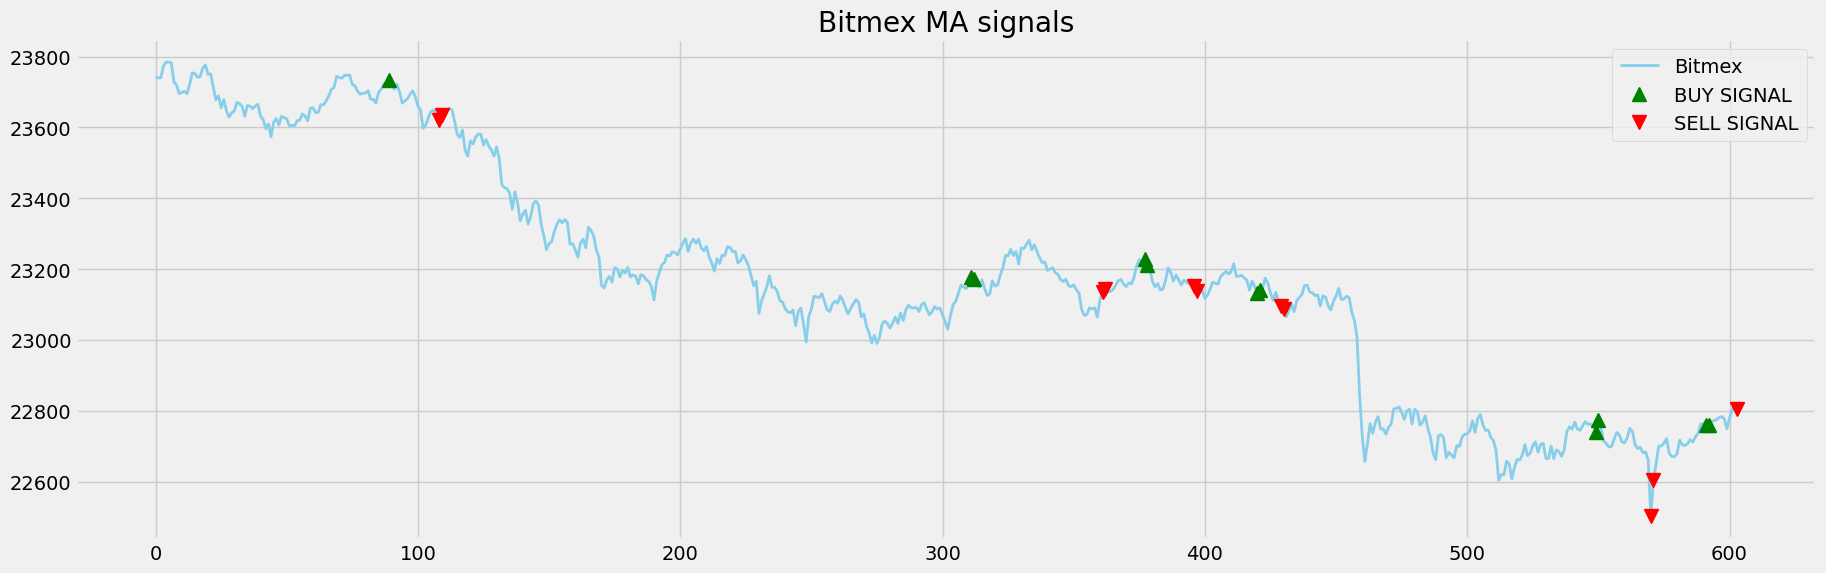

In [27]:
ax1 = plt.subplot2grid((8,1), (0,0), rowspan = 5, colspan = 1)

ax1.plot(close, color = 'skyblue', linewidth = 2, label = 'Bitmex')
ax1.plot(arange, buy_price, marker = '^', color = 'green', markersize = 10, label = 'BUY SIGNAL', linewidth = 0)
ax1.plot(arange, sell_price, marker = 'v', color = 'r', markersize = 10, label = 'SELL SIGNAL', linewidth = 0)
ax1.legend()
ax1.set_title('Bitmex MA signals')

In [28]:
position = []
for i in range(len(ma_signal)):
    if ma_signal[i] > 1:
        position.append(0)
    else:
        position.append(1)
        
for i in range(len(close)):
    if ma_signal[i] == 1:
        position[i] = 1
    elif ma_signal[i] == -1 or i == 0:
        position[i] = 0
    else:
        position[i] = position[i-1]
        
ma20 = ma_data['ma20']
ma90 = ma_data['ma90']

ma_signal = pd.DataFrame(ma_signal).rename(columns = {0:'ma_signal'}).set_index(ma_data.index)
position = pd.DataFrame(position).rename(columns = {0:'ma_position'}).set_index(ma_data.index)
close_price = pd.Series(close)
frames = [close_price, ma20, ma90, ma_signal, position]
strategy = pd.concat(frames, join = 'inner', axis = 1)

strategy

,0,ma20,ma90,ma_signal,ma_position
0,23741.50,NaN,NaN,0,0
1,23740.50,NaN,NaN,0,0
2,23740.75,NaN,NaN,0,0
3,23773.75,NaN,NaN,0,0
4,23784.75,NaN,NaN,0,0
...,...,...,...,...,...
599,22749.25,22742.7125,22706.800000,0,1
600,22778.75,22747.7125,22707.505556,0,1
601,22802.75,22751.9875,22708.783333,0,1
602,22820.25,22757.8125,22711.188889,0,1


Посчитаем профит. Получился минус. Если бы всё было так легко, то все бы давно стали миллионерами)

In [29]:
data = pd.DataFrame(np.diff(close)).rename(columns = {0:'returns'})
ma_strategy_ret = []

for i in range(len(data)):
    try:
        returns = data['returns'][i] * strategy['ma_position'][i]
        ma_strategy_ret.append(returns)
    except:
        pass
    
ma_strategy_ret_df = pd.DataFrame(ma_strategy_ret).rename(columns = {0:'ma_returns'})

investment_value = 1000000
number_of_stocks = floor(investment_value / close[0])
ma_investment_ret = []

for i in range(len(ma_strategy_ret_df['ma_returns'])):
    returns = number_of_stocks * ma_strategy_ret_df['ma_returns'][i]
    ma_investment_ret.append(returns)

ma_investment_ret_df = pd.DataFrame(ma_investment_ret).rename(columns = {0:'investment_returns'})
total_investment_ret = round(sum(ma_investment_ret_df['investment_returns']), 2)
profit_percentage = floor((total_investment_ret / investment_value) * 100)
print('Профит при вложении 1.000.000$: {}'.format(total_investment_ret))
print('Профит в процентах : {}%'.format(profit_percentage))

Профит при вложении 1.000.000$: -19582.5
Профит в процентах : -2%


Построим полосы Боллинджера. Касании графика цена верхней полосы может быть сигналом на продажу. Пример - 70 таймстемп. С касанием нижней полосы аналогично. Реализовывать не будем.

In [30]:
fig = go.Figure()
upper, middle, lower = BBANDS(close, 20, 2, 2)
fig.add_trace(go.Scatter(x=arange, y=close, name='close'))
fig.add_trace(go.Scatter(x=arange, y=upper, name='upper'))
fig.add_trace(go.Scatter(x=arange, y=middle, name='middle'))
fig.add_trace(go.Scatter(x=arange, y=lower, name='lower'))
fig.show()

Посмотрим на индикатор MACD. Здесь по аналогии со скользящими средними нас интересно пересечение 2 графиков, а так же их положение относительно друг друга

In [31]:
macd, macdSignal, macdHist = MACD(close)
macd_data = pd.DataFrame({'macd': macd, 'signal': macdSignal, 'hist': macdHist})
macd_data = macd_data.fillna(0)

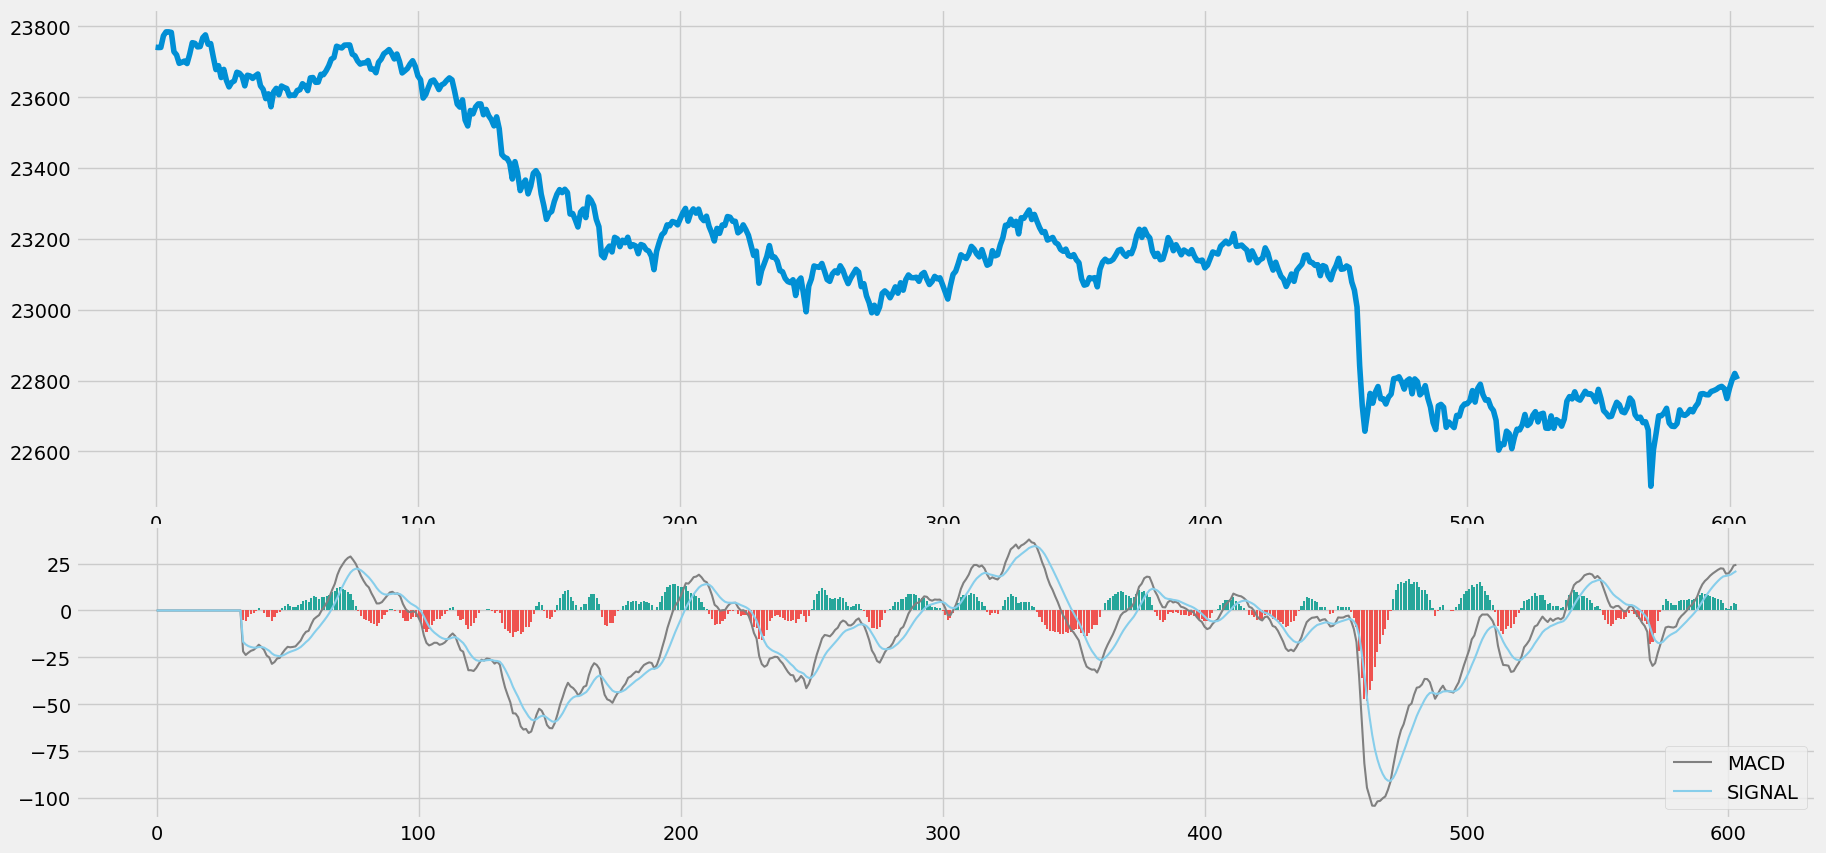

In [32]:
def plot_macd(prices, macd, signal, hist):
    ax1 = plt.subplot2grid((8,1), (0,0), rowspan = 5, colspan = 1)
    ax2 = plt.subplot2grid((8,1), (5,0), rowspan = 3, colspan = 1)

    ax1.plot(prices)
    ax2.plot(macd, color = 'grey', linewidth = 1.5, label = 'MACD')
    ax2.plot(signal, color = 'skyblue', linewidth = 1.5, label = 'SIGNAL')

    for i in range(len(prices)):
        if str(hist[i])[0] == '-':
            ax2.bar(i, hist[i], color = '#ef5350')
        else:
            ax2.bar(i, hist[i], color = '#26a69a')

    plt.legend(loc = 'lower right')

plot_macd(close, macd_data['macd'], macd_data['signal'], macd_data['hist'])

In [33]:
buy_price, sell_price, macd_signal = implement_strategy(close, macd_data, indicator='macd')

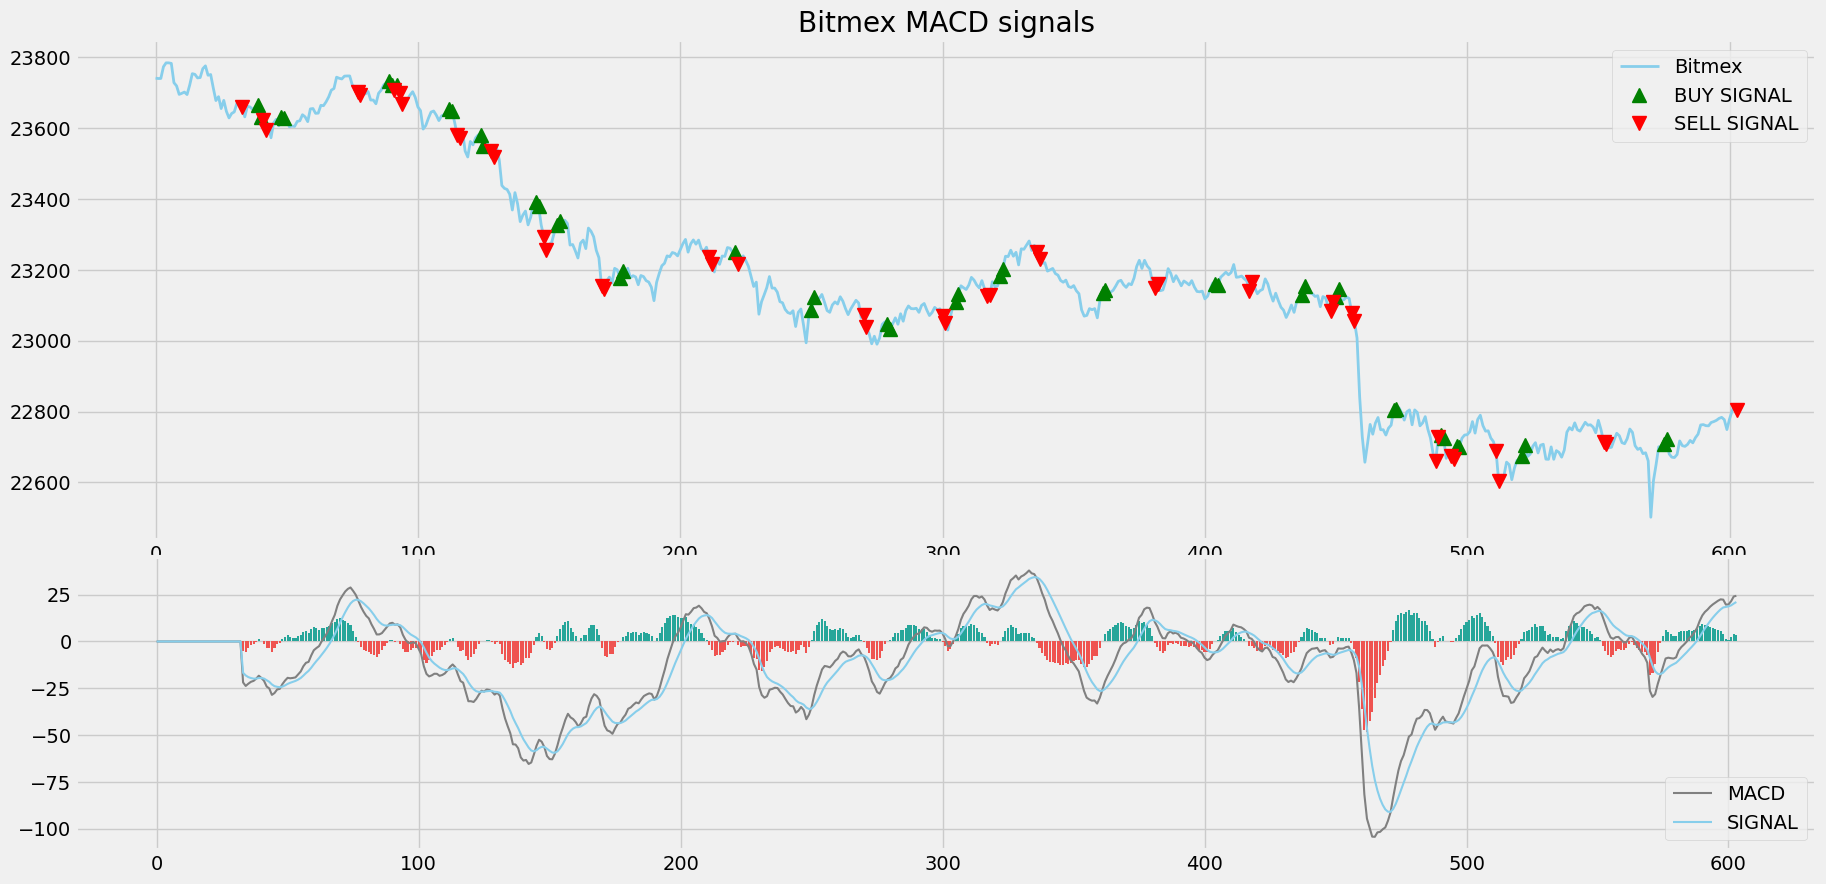

In [34]:
ax1 = plt.subplot2grid((8,1), (0,0), rowspan = 5, colspan = 1)
ax2 = plt.subplot2grid((8,1), (5,0), rowspan = 3, colspan = 1)

ax1.plot(close, color = 'skyblue', linewidth = 2, label = 'Bitmex')
ax1.plot(arange, buy_price, marker = '^', color = 'green', markersize = 10, label = 'BUY SIGNAL', linewidth = 0)
ax1.plot(arange, sell_price, marker = 'v', color = 'r', markersize = 10, label = 'SELL SIGNAL', linewidth = 0)
ax1.legend()
ax1.set_title('Bitmex MACD signals')
ax2.plot(macd_data['macd'], color = 'grey', linewidth = 1.5, label = 'MACD')
ax2.plot(macd_data['signal'], color = 'skyblue', linewidth = 1.5, label = 'SIGNAL')

for i in range(len(macd_data)):
    if str(macd_data['hist'][i])[0] == '-':
        ax2.bar(macd_data.index[i], macd_data['hist'][i], color = '#ef5350')
    else:
        ax2.bar(macd_data.index[i], macd_data['hist'][i], color = '#26a69a')
        
plt.legend(loc = 'lower right')
plt.show()

In [35]:
position = []
for i in range(len(macd_signal)):
    if macd_signal[i] > 1:
        position.append(0)
    else:
        position.append(1)
        
for i in range(len(close)):
    if macd_signal[i] == 1:
        position[i] = 1
    elif macd_signal[i] == -1 or i == 0:
        position[i] = 0
    else:
        position[i] = position[i-1]
        
macd = macd_data['macd']
signal = macd_data['signal']

macd_signal = pd.DataFrame(macd_signal).rename(columns = {0:'macd_signal'}).set_index(macd_data.index)
position = pd.DataFrame(position).rename(columns = {0:'macd_position'}).set_index(macd_data.index)
close_price = pd.Series(close)
frames = [close_price, macd, signal, macd_signal, position]
strategy = pd.concat(frames, join = 'inner', axis = 1)

strategy

,0,macd,signal,macd_signal,macd_position
0,23741.50,0.000000,0.000000,0,0
1,23740.50,0.000000,0.000000,0,0
2,23740.75,0.000000,0.000000,0,0
3,23773.75,0.000000,0.000000,0,0
4,23784.75,0.000000,0.000000,0,0
...,...,...,...,...,...
599,22749.25,19.700494,18.480409,0,1
600,22778.75,19.769626,18.738253,0,1
601,22802.75,21.513025,19.293207,0,1
602,22820.25,24.029784,20.240522,0,1


Тоже минус(

In [36]:
data = pd.DataFrame(np.diff(close)).rename(columns = {0:'returns'})
macd_strategy_ret = []

for i in range(len(data)):
    try:
        returns = data['returns'][i] * strategy['macd_position'][i]
        macd_strategy_ret.append(returns)
    except:
        pass
    
macd_strategy_ret_df = pd.DataFrame(macd_strategy_ret).rename(columns = {0:'macd_returns'})

investment_value = 1000000
number_of_stocks = floor(investment_value / close[0])
macd_investment_ret = []

for i in range(len(macd_strategy_ret_df['macd_returns'])):
    returns = number_of_stocks * macd_strategy_ret_df['macd_returns'][i]
    macd_investment_ret.append(returns)

macd_investment_ret_df = pd.DataFrame(macd_investment_ret).rename(columns = {0: 'investment_returns'})
total_investment_ret = round(sum(macd_investment_ret_df['investment_returns']), 2)
profit_percentage = floor((total_investment_ret / investment_value) * 100)
print('Профит при вложении 1.000.000$: {}'.format(total_investment_ret))
print('Профит в процентах: {}%'.format(profit_percentage))

Профит при вложении 1.000.000$: -19477.5
Профит в процентах: -2%
